# 2D 

## Calcules et repésentaions `simulation_gaz_2d.py`

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
import json

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"],
    "figure.figsize": (5, 5)
})


# ================================================================
# 🔹 1. Classe : système de particules
# ================================================================
import numpy as np

class ParticleSystem:
    def __init__(self, num_balls=100, box_size=5, ball_radius=0.09, dt=0.01, T=0.12, max_init_attempts=5000):
        self.num_balls = num_balls
        self.box_size = box_size
        self.ball_radius = ball_radius
        self.dt = dt
        self.T = T
        self.max_init_attempts = max_init_attempts

        self.positions = np.zeros((num_balls, 2))
        self.velocities = np.zeros((num_balls, 2))
        self.history_positions = []
        self.history_velocities = []

    # ==============================================================
    # 🔹 Initialisation des positions sans recouvrement
    # ==============================================================
    def init_positions(self, mode="uniform"):
        positions = []
        min_dist = 2 * self.ball_radius

        for n in range(self.num_balls):
            for attempt in range(self.max_init_attempts):
                if mode == "uniform":
                    candidate = np.random.rand(2) * self.box_size
                elif mode == "double_gaussian":
                    if n < self.num_balls // 2:
                        candidate = np.random.normal([1.5, 2.5], [0.3, 0.3])
                    else:
                        candidate = np.random.normal([3.5, 2.5], [0.3, 0.3])
                else:
                    raise ValueError(f"Mode inconnu : {mode}")

                # Vérifie la distance avec toutes les particules déjà placées
                if all(np.linalg.norm(candidate - p) >= min_dist for p in positions):
                    positions.append(candidate)
                    break
            else:
                raise RuntimeError(f"Impossible de placer la particule {n} sans chevauchement après {self.max_init_attempts} essais")

        self.positions = np.array(positions)

    # ==============================================================
    # 🔹 Initialisation des vitesses
    # ==============================================================
    def init_velocities(self, mode="double_gaussian"):
        if mode == "uniform":
            self.velocities = np.random.uniform(-1.0, 1.0, (self.num_balls, 2))
        elif mode == "maxwell":
            sigma = np.sqrt(self.T)
            self.velocities = np.random.normal(0.0, sigma, (self.num_balls, 2))
        elif mode == "double_gaussian":
            half = self.num_balls // 2
            mu = 0.5
            sigma = mu/10
            self.velocities[:half] = np.random.normal([-mu, -mu], [sigma, sigma], (half, 2))
            self.velocities[half:] = np.random.normal([mu, mu], [sigma, sigma], (self.num_balls - half, 2))
        else:
            raise ValueError(f"Mode inconnu : {mode}")

    # ==============================================================
    # 🔹 Mise à jour avec correction d'interpénétration
    # ==============================================================
    def update(self):
        """Mise à jour du système à chaque pas de temps."""
        self.positions += self.velocities * self.dt
        self.positions %= self.box_size  # bords périodiques
        self._handle_collisions()
        self.history_positions.append(np.copy(self.positions))
        self.history_velocities.append(np.copy(self.velocities))

    # ==============================================================
    # 🔹 Collisions élastiques avec correction géométrique
    # ==============================================================
    def _handle_collisions(self):
        for i in range(self.num_balls):
            for j in range(i + 1, self.num_balls):
                diff = self.positions[i] - self.positions[j]
                dist = np.linalg.norm(diff)

                if dist < 2 * self.ball_radius and dist > 0:
                    direction = diff / dist
                    dv = self.velocities[i] - self.velocities[j]
                    v_rel = np.dot(dv, direction)

                    # Collision seulement si les particules se rapprochent
                    if v_rel < 0:
                        impulse = v_rel * direction
                        self.velocities[i] -= impulse
                        self.velocities[j] += impulse

                        # Correction géométrique : repositionner les particules sans recouvrement
                        overlap = 2 * self.ball_radius - dist
                        correction = direction * (overlap / 2)
                        self.positions[i] += correction
                        self.positions[j] -= correction



# ================================================================
# 🔹 2. Classe : sauvegarde & chargement des données
# ================================================================
class SimulationRecorder:
    def __init__(self, system: ParticleSystem, output_dir="outputs"):
        self.system = system
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def save_data(self):
        """Sauvegarde toutes les données de la simulation."""
        np.savez(
            os.path.join(self.output_dir, "2D_simulation_data.npz"),
            positions=np.array(self.system.history_positions),
            velocities=np.array(self.system.history_velocities)
        )
        with open(os.path.join(self.output_dir, "2D_params.json"), "w") as f:
            json.dump({
                "num_balls": self.system.num_balls,
                "box_size": self.system.box_size,
                "ball_radius": self.system.ball_radius,
                "dt": self.system.dt,
                "T": self.system.T
            }, f, indent=4)
        print("✅ Données sauvegardées dans", self.output_dir)

    @staticmethod
    def load_data(input_dir="outputs"):
        """Charge les données enregistrées pour rejouer ou analyser."""
        data = np.load(os.path.join(input_dir, "2D_simulation_data.npz"))
        with open(os.path.join(input_dir, "2D_params.json")) as f:
            params = json.load(f)
        return data, params


# ================================================================
# 🔹 3. Classe : étude physique
# ================================================================
class PhysicalAnalysis:
    def __init__(self, positions, velocities):
        self.positions = positions
        self.velocities = velocities

    def compute_moments(self, order=2):
        v = np.linalg.norm(self.velocities, axis=2)
        return np.mean(v**order, axis=1)

    def animate_moments(self, output_dir="outputs", fps=20 ):
        fig, ax = plt.subplots()
        orders = [0, 1, 2, 3]
        lines = [ax.plot([], [], label=f"Ordre {n}")[0] for n in orders]
        ax.set_xlim(0, len(self.positions))
        ax.set_ylim(0, None)
        ax.legend()
        ax.set_title("Évolution des moments selon le temps")

        moments = [self.compute_moments(order=n) for n in orders]

        #print(moments)

        def update(frame):
            for n, line in enumerate(lines):
                line.set_data(np.arange(frame), moments[n][:frame])
            return lines

        ani = FuncAnimation(fig, update, frames=len(self.positions), blit=True, interval=100)
        ani.save(os.path.join(output_dir, "moments_evolution.mp4"), writer="ffmpeg", fps=fps)
        plt.close(fig)
        print("🎞️ Animation moments enregistrée.")


class VelocityAnalyzer:
    def __init__(self, system, output_dir="output"):
        self.system = system
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    # ================================================================
    # 🔹 CORRELATION D'ORDRE n
    # ================================================================
    def animate_correlation(self, order=2, fps=24):
        """
        Anime les corrélations d'ordre n des vitesses vx et vy.
        - Si n <= 2 : affiche une carte 2D + diagonale
        - Si n > 2  : affiche uniquement la diagonale moyenne
        """
        history = self.system.history_velocities
        Nframes = len(history)
        N = history[0].shape[0]

        fig, ax = plt.subplots(figsize=(5, 5))

        def update(frame):
            ax.cla()
            vxs = history[frame][:, 0]
            vys = history[frame][:, 1]

            # Corrélations d'ordre n (brute, sans centrage)
            Cx = np.outer(vxs, vxs)**(order//2)
            Cy = np.outer(vys, vys)**(order//2)

            # Moyenne sur la diagonale
            diag_x = np.diag(Cx)
            diag_y = np.diag(Cy)
            diag_mean = 0.5*(np.mean(diag_x) + np.mean(diag_y))

            if order <= 2:
                im = ax.imshow(Cx, cmap='viridis', origin='lower')
                #if frame == 0 : plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                ax.set_title(rf"$C^{{({order})}}_x(i,j)$ — frame {frame}", fontsize=14)
                ax.set_xlabel("i")
                ax.set_ylabel("j")
            else:
                ax.plot(np.arange(N), diag_x, color='goldenrod', label=r"$C_x$")
                ax.plot(np.arange(N), diag_y, color='royalblue', label=r"$C_y$")
                ax.set_title(rf"Corrélation diagonale d'ordre {order} — frame {frame}", fontsize=14)
                ax.set_xlabel("Indice particule $i$")
                ax.set_ylabel(rf"$C_{{ii}}^{{({order})}}$")
                ax.legend()
                ax.grid(True, linestyle='--', alpha=0.5)

            return ax

        ani = FuncAnimation(fig, update, frames=Nframes, interval=1000/fps, blit=False)
        output_path = os.path.join(self.output_dir, f"2D_correlation_order_{order}.mp4")
        ani.save(output_path, writer="ffmpeg", fps=fps)
        plt.close(fig)
        print(f"🎞️ Corrélation d'ordre {order} enregistrée : {output_path}")


    # ================================================================
    # 🔹 CUMULANT D'ORDRE n
    # ================================================================
    def animate_cumulant(self, order=2, fps=24):
        """
        Anime les cumulants d'ordre n des vitesses vx et vy.
        - Si n <= 2 : affiche une carte 2D + diagonale
        - Si n > 2  : affiche uniquement la diagonale moyenne
        """
        history = self.system.history_velocities
        Nframes = len(history)
        N = history[0].shape[0]

        fig, ax = plt.subplots(figsize=(5, 5))

        def update(frame):
            ax.cla()
            vxs = history[frame][:, 0]
            vys = history[frame][:, 1]

            # Centrage des vitesses
            dvx = vxs - np.mean(vxs)
            dvy = vys - np.mean(vys)

            # Cumulants d'ordre n
            Kx = np.outer(dvx, dvx)**(order//2)
            Ky = np.outer(dvy, dvy)**(order//2)

            diag_x = np.diag(Kx)
            diag_y = np.diag(Ky)

            if order <= 2:
                im = ax.imshow(Kx, cmap='plasma', origin='lower')
                #if frame == 0 :  plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                ax.set_title(rf"$K^{{({order})}}_x(i,j)$ — frame {frame}", fontsize=14)
                ax.set_xlabel("i")
                ax.set_ylabel("j")
            else:
                ax.plot(np.arange(N), diag_x, color='darkorange', label=r"$K_x$")
                ax.plot(np.arange(N), diag_y, color='navy', label=r"$K_y$")
                ax.set_title(rf"Cumulant diagonal d'ordre {order} — frame {frame}", fontsize=14)
                ax.set_xlabel("Indice particule $i$")
                ax.set_ylabel(rf"$K_{{ii}}^{{({order})}}$")
                ax.legend()
                ax.grid(True, linestyle='--', alpha=0.5)

            return ax

        ani = FuncAnimation(fig, update, frames=Nframes, interval=1000/fps, blit=False)
        output_path = os.path.join(self.output_dir, f"2D_cumulant_order_{order}.mp4")
        ani.save(output_path, writer="ffmpeg", fps=fps)
        plt.close(fig)
        print(f"🎞️ Cumulant d'ordre {order} enregistré : {output_path}")

# ================================================================
# 🔹 4. Classe : animation visuelle
# ================================================================
class AnimationManager:
    def __init__(self, system: ParticleSystem, output_dir="outputs"):
        self.system = system
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def animate_positions(self, n_frames=200, fps=24, fmt="mp4", show_grid=True):
        fig, ax = plt.subplots()
        ax.set_xlim(0, self.system.box_size)
        ax.set_ylim(0, self.system.box_size)
        ax.set_xticks([]); ax.set_yticks([])

        # Ajout de la grille manuelle
        if show_grid:
            for i in range(1, int(self.system.box_size)):
                ax.plot([i, i], [0, self.system.box_size], color='gray', linestyle='--', lw=0.5)
                ax.plot([0, self.system.box_size], [i, i], color='gray', linestyle='--', lw=0.5)

        scat, = ax.plot([], [], 'o', color='teal', ms=self.system.ball_radius * 100)

        def init():
            scat.set_data([], [])
            return scat,

        def update(frame):
            self.system.update()
            scat.set_data(self.system.positions[:, 0], self.system.positions[:, 1])
            return scat,

        ani = FuncAnimation(fig, update, frames=n_frames, init_func=init, blit=True, interval=50)
        path = os.path.join(self.output_dir, f"2D_positions_animation.{fmt}")
        ani.save(path, writer="ffmpeg", fps=fps, dpi=200)
        plt.close(fig)
        print("🎞️ Animation positions enregistrée :", path)

    

    def animate_2D_velocity_distribution(self, fps=24):
        

        # parametres gaussienne thermalisation
        vxs = self.system.history_velocities[0][:, 0]
        vys = self.system.history_velocities[0][:, 1]

        # --- Calcul des moyennes et écarts-types ---
        mean_vx, mean_vy = np.mean(vxs), np.mean(vys)
        sigma_vx, sigma_vy = np.std(vxs), np.std(vys)


        # --- Calculer les gaussiennes correspondantes ---
        def gaussian(v, mean, sigma): return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*((v - mean)/sigma)**2)

        vmax = int(max([mean_vx + 3*sigma_vx , mean_vy + 3*sigma_vy]))+1 
        pmax = max([gaussian(0, mean_vx, sigma_vx) , gaussian(0, mean_vy, sigma_vy)  ]) + 0.005 
        
        v = np.linspace(-vmax, vmax, 300)
        vx_therm , vy_therm = gaussian(v, mean_vx, sigma_vx), gaussian(v, mean_vy, sigma_vy)


        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(-vmax, vmax)
        ax.set_ylim(0, pmax)  # normalisé
        ax.set_xlabel(r"Vitesse $v_x, v_y$", fontsize=12)
        ax.set_ylabel(r"Densité de probabilité $P(v)$", fontsize=12)
        ax.set_title(r"Distribution normalisée des vitesses $v_x$ et $v_y$", fontsize=14)
        
        # Initialisation vide
        bins = np.linspace(-vmax, vmax, 30)
        hist_vx = ax.bar(bins[:-1], np.zeros_like(bins[:-1]), width=bins[1]-bins[0],
                         color='goldenrod', alpha=0.6, label=r"$v_x$")
        hist_vy = ax.bar(bins[:-1], np.zeros_like(bins[:-1]), width=bins[1]-bins[0],
                         color='royalblue', alpha=0.4, label=r"$v_y$")
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.5)
    
        def update(frame):
            ax.cla()  # efface le contenu précédent
            
            vxs = self.system.history_velocities[frame][:, 0]
            vys = self.system.history_velocities[frame][:, 1]
            
            # Histogrammes normalisés
            ax.hist(vxs, bins=bins, density=True, color='goldenrod', alpha=0.4, label=r"$v_x$")
            ax.hist(vys, bins=bins, density=True, color='royalblue', alpha=0.4, label=r"$v_y$")

            # --- Tracer les gaussiennes correspondantes ---
            ax.plot(v, vx_therm, color='goldenrod', lw=2, linestyle='--', alpha=1)#,  label=rf"Gaussienne $v_x$ ($\mu$={mean_vx:.2f}, $\sigma$={sigma_vx:.2f})")
            ax.plot(v, vy_therm, color='royalblue', lw=2, linestyle='--', alpha=1)#, label=rf"Gaussienne $v_y$ ($\mu$={mean_vy:.2f}, $\sigma$={sigma_vy:.2f})")


            # --- Habillage graphique ---
            ax.set_xlim(-vmax, vmax)
            ax.set_ylim(0, pmax)
            ax.set_xlabel(r"Vitesse $v_x, v_y$", fontsize=12)
            ax.set_ylabel(r"Densité de probabilité $P(v)$", fontsize=12)
            ax.set_title(rf"Distribution normalisée des vitesses — frame {frame}", fontsize=14)
            #ax.set_title(rf"Thermalisation des vitesses — frame {frame}", fontsize=14)
            # ✅ Légende fixée
            ax.legend(fontsize=9, loc='upper right', frameon=True, facecolor='white', edgecolor='gray')

            ax.grid(True, linestyle='--', alpha=0.5)
            return ax
    
        ani = FuncAnimation(fig, update, frames=len(self.system.history_velocities),
                            interval=1000/fps, blit=False)
        
        output_path = os.path.join(self.output_dir, "2D_velocity_distribution.mp4")
        ani.save(output_path, writer="ffmpeg", fps=fps)
        plt.close(fig)
        print(f"🎞️ Animation des distributions de vitesses enregistrée dans {output_path}.")


    def animate_moment_ordre_n_distribution(self, fps=24 , ordre = 2 ):
        

        # parametres gaussienne thermalisation
        vxs = self.system.history_velocities[0][:, 0]
        vys = self.system.history_velocities[0][:, 1]

        # --- Calcul des moyennes et écarts-types ---
        mean_vx, mean_vy = np.mean(vxs), np.mean(vys)
        sigma_vx, sigma_vy = np.std(vxs), np.std(vys)


        # --- Calculer les gaussiennes correspondantes ---
        def gaussian_X(v, mean, sigma): return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*((v - mean)/sigma)**2)       

        def gaussian_Y(v, mean, sigma) : return  1/( ordre * np.power(np.abs(v),1-1/ordre)) * gaussian_X(v, mean, sigma) 

        vmax = int(max([(mean_vx + 3*sigma_vx)**ordre , (mean_vy + 3*sigma_vy)**ordre]))+1 
        
        
        if ordre % 2 == 1 :  
            vmax_min  = -vmax
            if ordre == 1 :
                pmax = max([gaussian_X(0, mean_vx, sigma_vx) , gaussian_X(0, mean_vy, sigma_vy)  ]) + 0.005 
            else :
                pmax = 1 #max([gaussian_Y(0.000001, mean_vx, sigma_vx) , gaussian_Y(0.000001, mean_vy, sigma_vy)  ]) + 0.005 
        else : 
            vmax_min  = 0
            pmax = 1 #max([gaussian_Y(0.1, mean_vx, sigma_vx) , gaussian_Y(0.1, mean_vy, sigma_vy)  ]) + 0.005 
            
        v = np.linspace(vmax_min, vmax, 300)
        vx_therm , vy_therm = gaussian_Y(v, mean_vx, sigma_vx), gaussian_Y(v, mean_vy, sigma_vy)


        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(vmax_min, vmax)
        ax.set_ylim(0, pmax)  # normalisé
        
        # Initialisation vide
        bins = np.linspace(vmax_min, vmax, int(30*ordre))
        hist_vx = ax.bar(bins[:-1], np.zeros_like(bins[:-1]), width=bins[1]-bins[0],
                         color='goldenrod', alpha=0.6, label=rf"$v_x^{ordre}$")
        hist_vy = ax.bar(bins[:-1], np.zeros_like(bins[:-1]), width=bins[1]-bins[0],
                         color='royalblue', alpha=0.4, label=rf"$v_y^{ordre}$")
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.5)
    
        def update(frame):
            ax.cla()  # efface le contenu précédent
            
            vxs = self.system.history_velocities[frame][:, 0]
            vys = self.system.history_velocities[frame][:, 1]
            
            # Histogrammes normalisés
            ax.hist(vxs, bins=bins, density=True, color='goldenrod', alpha=0.4, label=rf"$v_x^{ordre}$")
            ax.hist(vys, bins=bins, density=True, color='royalblue', alpha=0.4, label=rf"$v_y^{ordre}$")

            # --- Tracer les gaussiennes correspondantes ---
            ax.plot(v, vx_therm, color='goldenrod', lw=2, linestyle='--', alpha=1)#,  label=rf"Gaussienne $v_x$ ($\mu$={mean_vx:.2f}, $\sigma$={sigma_vx:.2f})")
            ax.plot(v, vy_therm, color='royalblue', lw=2, linestyle='--', alpha=1)#, label=rf"Gaussienne $v_y$ ($\mu$={mean_vy:.2f}, $\sigma$={sigma_vy:.2f})")


            # --- Habillage graphique ---
            ax.set_xlim(vmax_min, vmax)
            ax.set_ylim(0, pmax)
            ax.set_xlabel(rf"$v_x^{ordre}, v_y^{ordre}$", fontsize=12)
            ax.set_ylabel(rf"Densité de probabilité $P(v^{ordre})$", fontsize=12)
            ax.set_title(rf"Distribution normalisée des vitesses$^{ordre}$ — frame {frame}", fontsize=14)
            # ✅ Légende fixée
            ax.legend(fontsize=9, loc='upper right', frameon=True, facecolor='white', edgecolor='gray')

            ax.grid(True, linestyle='--', alpha=0.5)
            return ax
    
        ani = FuncAnimation(fig, update, frames=len(self.system.history_velocities),
                            interval=1000/fps, blit=False)
        
        output_path = os.path.join(self.output_dir, f"2D_velocity_distribution_order_{ordre}.mp4")
        ani.save(output_path, writer="ffmpeg", fps=fps)
        plt.close(fig)
        print(f"🎞️ Animation des distributions de vitesses order : {ordre} enregistrée dans {output_path}.")



# ================================================================
# 🔹 5. Exemple d’utilisation
# ================================================================
if __name__ == "__main__":
    system = ParticleSystem(num_balls=350, T=10.0)
    system.init_positions("uniform")
    system.init_velocities("double_gaussian")

    anim = AnimationManager(system)
    anim.animate_positions(n_frames=600, fps=60, fmt="mp4")
    anim.animate_2D_velocity_distribution(fps=60)
    anim.animate_moment_ordre_n_distribution(fps=60, ordre = 1 )
    anim.animate_moment_ordre_n_distribution(fps=60, ordre = 2 )
    anim.animate_moment_ordre_n_distribution(fps=60, ordre = 3 )
    anim.animate_moment_ordre_n_distribution(fps=60, ordre = 4 )
    anim.animate_moment_ordre_n_distribution(fps=60, ordre = 5 )
    anim.animate_moment_ordre_n_distribution(fps=60, ordre = 6 )

    #recorder = SimulationRecorder(system)
    #recorder.save_data()

    #data, _ = SimulationRecorder.load_data()
    #analysis = PhysicalAnalysis(data["positions"], data["velocities"])
    #analysis.animate_moments()
    ### Correlation et Cummulante a finie 
    #analyzer = VelocityAnalyzer(system, output_dir="animations")
    #analyzer.animate_correlation(order=2)
    #analyzer.animate_cumulant(order=2)



🎞️ Animation positions enregistrée : outputs/2D_positions_animation.mp4
🎞️ Animation des distributions de vitesses enregistrée dans outputs/2D_velocity_distribution.mp4.
🎞️ Animation des distributions de vitesses order : 1 enregistrée dans outputs/2D_velocity_distribution_order_1.mp4.


/var/folders/sc/1jlhfymx3sg5vz8q1fx87pvr0000gn/T/ipykernel_87888/4163259945.py:433: RuntimeWarning: divide by zero encountered in divide
  def gaussian_Y(v, mean, sigma) : return  1/( ordre * np.power(np.abs(v),1-1/ordre)) * gaussian_X(v, mean, sigma)


🎞️ Animation des distributions de vitesses order : 2 enregistrée dans outputs/2D_velocity_distribution_order_2.mp4.
🎞️ Animation des distributions de vitesses order : 3 enregistrée dans outputs/2D_velocity_distribution_order_3.mp4.


/var/folders/sc/1jlhfymx3sg5vz8q1fx87pvr0000gn/T/ipykernel_87888/4163259945.py:433: RuntimeWarning: divide by zero encountered in divide
  def gaussian_Y(v, mean, sigma) : return  1/( ordre * np.power(np.abs(v),1-1/ordre)) * gaussian_X(v, mean, sigma)


🎞️ Animation des distributions de vitesses order : 4 enregistrée dans outputs/2D_velocity_distribution_order_4.mp4.
🎞️ Animation des distributions de vitesses order : 5 enregistrée dans outputs/2D_velocity_distribution_order_5.mp4.


/var/folders/sc/1jlhfymx3sg5vz8q1fx87pvr0000gn/T/ipykernel_87888/4163259945.py:433: RuntimeWarning: divide by zero encountered in divide
  def gaussian_Y(v, mean, sigma) : return  1/( ordre * np.power(np.abs(v),1-1/ordre)) * gaussian_X(v, mean, sigma)


🎞️ Animation des distributions de vitesses order : 6 enregistrée dans outputs/2D_velocity_distribution_order_6.mp4.


## Visualiser Donner 

In [ ]:
import numpy as np

# Charger le fichier
data = np.load('./outputs/2D_simulation_data.npz')

# Afficher la liste des tableaux contenus dans le fichier
print("Clés disponibles :", data.files)

# Afficher le contenu de chaque tableau
for key in data.files:
    print(f"\n--- {key} ---")
    print(data[key])
    print("Shape :", data[key].shape)


## probabilié X^N

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Paramètres ---
mu, sigma = 0, 1
N = 3
size = 10_0000

# --- Simulation ---
x = np.random.normal(mu, sigma, size)
y = x**N

# --- Tracé ---
plt.figure(figsize=(6,4))
plt.hist(y, bins=100, density=True, color="goldenrod", alpha=0.6, label=fr"$Y = X^{N}$, N={N}")
plt.xlabel(r"$Y$")
plt.ylabel(r"$P(Y)$")
plt.title(fr"Distribution de $Y = X^{N}$ pour $X \sim \mathcal{{N}}(0,1)$")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


/var/folders/sc/1jlhfymx3sg5vz8q1fx87pvr0000gn/T/ipykernel_87888/480240263.py:16: RuntimeWarning: invalid value encountered in power
  pY = norm.pdf(np.power(y, 1/N), mu, sigma) / (N * np.abs(y)**(1 - 1/N))


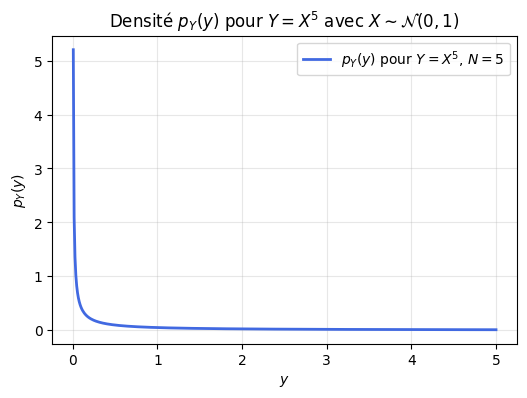

∫p_Y(y) dy = nan


/var/folders/sc/1jlhfymx3sg5vz8q1fx87pvr0000gn/T/ipykernel_87888/480240263.py:37: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(pY, y)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def pdf_power_normal(y, N, mu=0, sigma=1):
    """Renvoie la densité pY(y) pour Y = X^N, avec X ~ N(mu, sigma^2)."""
    y = np.array(y)
    px_pos = norm.pdf(np.power(np.abs(y), 1/N), mu, sigma)
    
    if N % 2 == 0:  # N pair → y > 0
        pY = np.zeros_like(y)
        mask = y > 0
        pY[mask] = (norm.pdf(np.power(y[mask], 1/N), mu, sigma)
                   + norm.pdf(-np.power(y[mask], 1/N), mu, sigma)) / (N * np.power(y[mask], 1 - 1/N))
    else:  # N impair
        pY = norm.pdf(np.power(y, 1/N), mu, sigma) / (N * np.abs(y)**(1 - 1/N))
    
    return pY

# --- Test ---
mu, sigma = 0, 1
N = 5
y = np.linspace(-5, 5, 1000)
pY = pdf_power_normal(y, N, mu, sigma)

# --- Plot ---
plt.figure(figsize=(6,4))
plt.plot(y, pY, color='royalblue', lw=2, label=fr"$p_Y(y)$ pour $Y=X^{N}$, $N={N}$")
plt.xlabel(r"$y$")
plt.ylabel(r"$p_Y(y)$")
plt.title(fr"Densité $p_Y(y)$ pour $Y = X^{N}$ avec $X \sim \mathcal{{N}}(0,1)$")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Vérif de la normalisation ---
area = np.trapz(pY, y)
print("∫p_Y(y) dy =", area)


# 1D 

## Calcules et repésentaions `simulation_gaz_1d.py`

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
import json

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"],
    "figure.figsize": (5, 5)
})


# ================================================================
# 🔹 1. Classe : système de particules
# ================================================================
import numpy as np

class ParticleSystem:
    def __init__(self, num_balls=100, box_size=5, ball_radius=0.09, dt=0.01, T=0.12, max_init_attempts=5000):
        self.num_balls = num_balls
        self.box_size = box_size
        self.ball_radius = ball_radius
        self.dt = dt
        self.T = T
        self.max_init_attempts = max_init_attempts

        self.positions = np.zeros((num_balls, 1))
        self.velocities = np.zeros((num_balls, 1))
        self.history_positions = []
        self.history_velocities = []

    # ==============================================================
    # 🔹 Initialisation des positions sans recouvrement
    # ==============================================================
    def init_positions(self, mode="uniform"):
        positions = []
        min_dist = 2 * self.ball_radius

        for n in range(self.num_balls):
            for attempt in range(self.max_init_attempts):
                if mode == "uniform":
                    candidate = np.random.rand(1) * self.box_size
                elif mode == "double_gaussian":
                    if n < self.num_balls // 2:
                        candidate = np.random.normal(1.5, 0.3)
                    else:
                        candidate = np.random.normal(3.5, 0.3)
                else:
                    raise ValueError(f"Mode inconnu : {mode}")

                # Vérifie la distance avec toutes les particules déjà placées
                if all(np.linalg.norm(candidate - p) >= min_dist for p in positions):
                    positions.append(candidate)
                    break
            else:
                raise RuntimeError(f"Impossible de placer la particule {n} sans chevauchement après {self.max_init_attempts} essais")

        self.positions = np.array(positions)

    # ==============================================================
    # 🔹 Initialisation des vitesses
    # ==============================================================
    def init_velocities(self, mode="double_gaussian"):
        if mode == "uniform":
            self.velocities = np.random.uniform(-1.0, 1.0, (self.num_balls, 1))
        elif mode == "maxwell":
            sigma = np.sqrt(self.T)
            self.velocities = np.random.normal(0.0, sigma, (self.num_balls, 1))
        elif mode == "double_gaussian":
            half = self.num_balls // 2
            mu = 1
            sigma = 1
            self.velocities[:half] = np.random.normal(-mu, sigma, (half, 1))
            self.velocities[half:] = np.random.normal(mu, sigma, (self.num_balls - half, 1))
        else:
            raise ValueError(f"Mode inconnu : {mode}")

    # ==============================================================
    # 🔹 Mise à jour avec correction d'interpénétration
    # ==============================================================
    def update(self):
        """Mise à jour du système à chaque pas de temps."""
        self.positions += self.velocities * self.dt
        self.positions %= self.box_size  # bords périodiques
        self._handle_collisions()
        self.history_positions.append(np.copy(self.positions))
        self.history_velocities.append(np.copy(self.velocities))

    # ==============================================================
    # 🔹 Collisions élastiques avec correction géométrique
    # ==============================================================
    def _handle_collisions(self):
        for i in range(self.num_balls):
            for j in range(i + 1, self.num_balls):
                diff = self.positions[i] - self.positions[j]
                dist = np.linalg.norm(diff)

                if dist < 2 * self.ball_radius and dist > 0:
                    direction = diff / dist
                    dv = self.velocities[i] - self.velocities[j]
                    v_rel = np.dot(dv, direction)

                    # Collision seulement si les particules se rapprochent
                    if v_rel < 0:
                        impulse = v_rel * direction
                        self.velocities[i] -= impulse
                        self.velocities[j] += impulse

                        # Correction géométrique : repositionner les particules sans recouvrement
                        overlap = 2 * self.ball_radius - dist
                        correction = direction * (overlap / 2)
                        self.positions[i] += correction
                        self.positions[j] -= correction



# ================================================================
# 🔹 2. Classe : sauvegarde & chargement des données
# ================================================================
class SimulationRecorder:
    def __init__(self, system: ParticleSystem, output_dir="outputs"):
        self.system = system
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def save_data(self):
        """Sauvegarde toutes les données de la simulation."""
        np.savez(
            os.path.join(self.output_dir, "1D_simulation_data.npz"),
            positions=np.array(self.system.history_positions),
            velocities=np.array(self.system.history_velocities)
        )
        with open(os.path.join(self.output_dir, "1D_params.json"), "w") as f:
            json.dump({
                "num_balls": self.system.num_balls,
                "box_size": self.system.box_size,
                "ball_radius": self.system.ball_radius,
                "dt": self.system.dt,
                "T": self.system.T
            }, f, indent=4)
        print("✅ Données sauvegardées dans", self.output_dir)

    @staticmethod
    def load_data(input_dir="outputs"):
        """Charge les données enregistrées pour rejouer ou analyser."""
        data = np.load(os.path.join(input_dir, "1D_simulation_data.npz"))
        with open(os.path.join(input_dir, "1D_params.json")) as f:
            params = json.load(f)
        return data, params


# ================================================================
# 🔹 3. Classe : étude physique
# ================================================================

class VelocityAnalyzer:
    def __init__(self, system, output_dir="output"):
        self.system = system
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    # ================================================================
    # 🔹 CORRELATION D'ORDRE n
    # ================================================================
    def animate_correlation(self, order=2, fps=24):
        """
        Anime les corrélations d'ordre n de la  vitesses v.
        - Si n <= 2 : affiche une carte 2D + diagonale
        - Si n > 2  : affiche uniquement la diagonale moyenne
        """
        history = self.system.history_velocities
        Nframes = len(history)
        N = history[0].shape[0]

        fig, ax = plt.subplots(figsize=(5, 5))

        def update(frame):
            ax.cla()
            vs = history[frame]

            # Corrélations d'ordre n (brute, sans centrage)
            C = np.outer(vs, vs)**(order//2)

            # Moyenne sur la diagonale
            diag = np.diag(C)

            if order <= 2:
                im = ax.imshow(C, cmap='viridis', origin='lower')
                #if frame == 0 : plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                ax.set_title(rf"$C^{{({order})}}_x(i,j)$ — frame {frame}", fontsize=14)
                ax.set_xlabel("i")
                ax.set_ylabel("j")
            else:
                ax.plot(np.arange(N), diag, color='goldenrod', label=r"$C$")
                ax.set_title(rf"Corrélation diagonale d'ordre {order} — frame {frame}", fontsize=14)
                ax.set_xlabel("Indice particule $i$")
                ax.set_ylabel(rf"$C_{{ii}}^{{({order})}}$")
                ax.legend()
                ax.grid(True, linestyle='--', alpha=0.5)

            return ax

        ani = FuncAnimation(fig, update, frames=Nframes, interval=1000/fps, blit=False)
        output_path = os.path.join(self.output_dir, f"1D_correlation_order_{order}.mp4")
        ani.save(output_path, writer="ffmpeg", fps=fps)
        plt.close(fig)
        print(f"🎞️ Corrélation d'ordre {order} enregistrée : {output_path}")


    # ================================================================
    # 🔹 CUMULANT D'ORDRE n
    # ================================================================
    def animate_cumulant(self, order=2, fps=24):
        """
        Anime les cumulants d'ordre n de la vitesses v.
        - Si n <= 2 : affiche une carte 2D + diagonale
        - Si n > 2  : affiche uniquement la diagonale moyenne
        """
        history = self.system.history_velocities
        Nframes = len(history)
        N = history[0].shape[0]

        fig, ax = plt.subplots(figsize=(5, 5))

        def update(frame):
            ax.cla()
            vs = history[frame]

            # Centrage des vitesses
            dv = vs - np.mean(vs)

            # Cumulants d'ordre n
            K = np.outer(dv, dv)**(order//2)

            diag = np.diag(K)

            if order <= 2:
                im = ax.imshow(Kx, cmap='plasma', origin='lower')
                #if frame == 0 :  plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                ax.set_title(rf"$K^{{({order})}}_x(i,j)$ — frame {frame}", fontsize=14)
                ax.set_xlabel("i")
                ax.set_ylabel("j")
            else:
                ax.plot(np.arange(N), diag_x, color='darkorange', label=r"$K$")
                ax.set_title(rf"Cumulant diagonal d'ordre {order} — frame {frame}", fontsize=14)
                ax.set_xlabel("Indice particule $i$")
                ax.set_ylabel(rf"$K_{{ii}}^{{({order})}}$")
                ax.legend()
                ax.grid(True, linestyle='--', alpha=0.5)

            return ax

        ani = FuncAnimation(fig, update, frames=Nframes, interval=1000/fps, blit=False)
        output_path = os.path.join(self.output_dir, f"1D_cumulant_order_{order}.mp4")
        ani.save(output_path, writer="ffmpeg", fps=fps)
        plt.close(fig)
        print(f"🎞️ Cumulant d'ordre {order} enregistré : {output_path}")

# ================================================================
# 🔹 4. Classe : animation visuelle
# ================================================================
class AnimationManager:
    def __init__(self, system: ParticleSystem, output_dir="outputs"):
        self.system = system
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def animate_positions(self, n_frames=200, fps=24, fmt="mp4", show_grid=True):
        # --- Dimensions proportionnelles à la boîte ---
        aspect_ratio = 0.1  # rapport hauteur/largeur pour ne pas avoir trop d’espace vertical
        fig, ax = plt.subplots(figsize=(6, 6 * aspect_ratio))
        ax.set_aspect('equal')  # Réglez l'aspect de l'axe pour qu'il soit égal
        #ax.set(xlim=(0, self.system.box_size), ylim=(-self.system.ball_radius, self.system.ball_radius))  # L'axe y est fixé à une plage arbitraire car il n'y a qu'une dimension

        ax.set_xlim(0, self.system.box_size)
        ax.set_ylim(-self.system.ball_radius, self.system.ball_radius)
        #ax.set_ylim(-1, 1)
        ax.set_xticks([]); ax.set_yticks([])

        # Ajout de la grille manuelle
        if show_grid:
            for i in range(1, int(self.system.box_size)):
                ax.plot([i, i], [-self.system.ball_radius, self.system.ball_radius ], color='gray', linestyle='--', lw=0.5)
            ax.plot([0, self.system.box_size], [self.system.ball_radius, self.system.ball_radius], color='gray', linestyle='--', lw=0.5)
            ax.plot([0, self.system.box_size], [-self.system.ball_radius, -self.system.ball_radius], color='gray', linestyle='--', lw=0.5)

        scat, = ax.plot([], [], 'o', color='teal', ms=self.system.ball_radius * 100)

        def init():
            scat.set_data([],[])
            return scat,

        def update(frame):
            self.system.update()
            scat.set_data(self.system.positions , self.system.positions*0 )
            return scat,

        ani = FuncAnimation(fig, update, frames=n_frames, init_func=init, blit=True, interval=50)
        path = os.path.join(self.output_dir, f"1D_positions_animation.{fmt}")
        ani.save(path, writer="ffmpeg", fps=fps, dpi=200)
        plt.close(fig)
        print("🎞️ Animation positions enregistrée :", path)

    

    def animate_1D_velocity_distribution(self, fps=24):
        

        # parametres gaussienne thermalisation
        vs = self.system.history_velocities[0]

        # --- Calcul des moyennes et écarts-types ---
        mean_v = np.mean(vs)
        sigma_v = np.std(vs)


        # --- Calculer les gaussiennes correspondantes ---
        def gaussian(v, mean, sigma): return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*((v - mean)/sigma)**2)

        vmax = int(mean_v + 3*sigma_v) + 1 
        pmax = 1 #gaussian(0, mean_v, sigma_v) + 0.005 
        
        v = np.linspace(-vmax, vmax, 300)
        v_therm  = gaussian(v, mean_v, sigma_v)


        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(-vmax, vmax)
        ax.set_ylim(0, pmax)  # normalisé
        ax.set_xlabel(r"Vitesse $v$", fontsize=12)
        ax.set_ylabel(r"Densité de probabilité $P(v)$", fontsize=12)
        ax.set_title(r"Distribution normalisée de la  vitesse $v$", fontsize=14)
        
        # Initialisation vide
        bins = np.linspace(-vmax, vmax, 30)
        hist_v = ax.bar(bins[:-1], np.zeros_like(bins[:-1]), width=bins[1]-bins[0],
                         color='goldenrod', alpha=0.6, label=r"$v$")
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.5)
    
        def update(frame):
            ax.cla()  # efface le contenu précédent
            
            vs = self.system.history_velocities[frame]
            
            # Histogrammes normalisés
            ax.hist(vs, bins=bins, density=True, color='goldenrod', alpha=0.4, label=r"$v$")

            # --- Tracer les gaussiennes correspondantes ---
            #ax.plot(v, v_therm, color='goldenrod', lw=2, linestyle='--', alpha=1)#,  label=rf"Gaussienne $v_x$ ($\mu$={mean_vx:.2f}, $\sigma$={sigma_vx:.2f})")
            
            # --- Habillage graphique ---
            ax.set_xlim(-vmax, vmax)
            ax.set_ylim(0, pmax)
            ax.set_xlabel(r"Vitesse $v$", fontsize=12)
            ax.set_ylabel(r"Densité de probabilité $P(v)$", fontsize=12)
            ax.set_title(rf"Distribution normalisée de la vitesse — frame {frame}", fontsize=14)
            #ax.set_title(rf"Thermalisation des vitesses — frame {frame}", fontsize=14)
            # ✅ Légende fixée
            ax.legend(fontsize=9, loc='upper right', frameon=True, facecolor='white', edgecolor='gray')

            ax.grid(True, linestyle='--', alpha=0.5)
            return ax
    
        ani = FuncAnimation(fig, update, frames=len(self.system.history_velocities),
                            interval=1000/fps, blit=False)
        
        output_path = os.path.join(self.output_dir, "1D_velocity_distribution.mp4")
        ani.save(output_path, writer="ffmpeg", fps=fps)
        plt.close(fig)
        print(f"🎞️ Animation des distributions de vitesses enregistrée dans {output_path}.")


    def animate_moment_ordre_n_distribution(self, fps=24 , ordre = 2 ):
        

        # parametres gaussienne thermalisation
        vs = self.system.history_velocities[0]

        # --- Calcul des moyennes et écarts-types ---
        mean_v = np.mean(vs)
        sigma_v = np.std(vs)


        # --- Calculer les gaussiennes correspondantes ---
        def gaussian_X(v, mean, sigma): return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*((v - mean)/sigma)**2)       

        def gaussian_Y(v, mean, sigma) : return  1/( ordre * np.power(np.abs(v),1-1/ordre)) * gaussian_X(v, mean, sigma) 

        vmax = int((mean_v + 3*sigma_v)**ordre) +1 
        
        
        if ordre % 2 == 1 :  
            vmax_min  = -vmax
            if ordre == 1 :
                pmax = gaussian_X(0, mean_v, sigma_v)  + 0.005 
            else :
                pmax = 1 # gaussian_Y(0.000001, mean_v, sigma_v)  + 0.005 
        else : 
            vmax_min  = 0
            pmax = 1 # gaussian_Y(0.1, mean_v, sigma_v) + 0.005 
            
        v = np.linspace(vmax_min, vmax, 300)
        v_therm  = gaussian_Y(v, mean_v, sigma_v)


        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(vmax_min, vmax)
        ax.set_ylim(0, pmax)  # normalisé
        
        # Initialisation vide
        bins = np.linspace(vmax_min, vmax, int(30*ordre))
        hist_v = ax.bar(bins[:-1], np.zeros_like(bins[:-1]), width=bins[1]-bins[0],
                         color='goldenrod', alpha=0.6, label=rf"$v^{ordre}$")

        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.5)
    
        def update(frame):
            ax.cla()  # efface le contenu précédent
            
            vs = self.system.history_velocities[frame]
            
            # Histogrammes normalisés
            ax.hist(vs, bins=bins, density=True, color='goldenrod', alpha=0.4, label=rf"$v^{ordre}$")

            # --- Tracer les gaussiennes correspondantes ---
            ax.plot(v, v_therm, color='goldenrod', lw=2, linestyle='--', alpha=1)#,  label=rf"Gaussienne $v_x$ ($\mu$={mean_vx:.2f}, $\sigma$={sigma_vx:.2f})")

            # --- Habillage graphique ---
            ax.set_xlim(vmax_min, vmax)
            ax.set_ylim(0, pmax)
            ax.set_xlabel(rf"$v^{ordre}$", fontsize=12)
            ax.set_ylabel(rf"Densité de probabilité $P(v^{ordre})$", fontsize=12)
            ax.set_title(rf"Distribution normalisée de la vitesse$^{ordre}$ — frame {frame}", fontsize=14)
            # ✅ Légende fixée
            ax.legend(fontsize=9, loc='upper right', frameon=True, facecolor='white', edgecolor='gray')

            ax.grid(True, linestyle='--', alpha=0.5)
            return ax
    
        ani = FuncAnimation(fig, update, frames=len(self.system.history_velocities),
                            interval=1000/fps, blit=False)
        
        output_path = os.path.join(self.output_dir, f"1D_velocity_distribution_order_{ordre}.mp4")
        ani.save(output_path, writer="ffmpeg", fps=fps)
        plt.close(fig)
        print(f"🎞️ Animation des distributions de vitesses order : {ordre} enregistrée dans {output_path}.")



# ================================================================
# 🔹 5. Exemple d’utilisation
# ================================================================
if __name__ == "__main__":
    system = ParticleSystem(num_balls=10, T=10.0)
    system.init_positions("uniform")
    system.init_velocities("double_gaussian")

    anim = AnimationManager(system)
    anim.animate_positions(n_frames=600, fps=60, fmt="mp4")
    anim.animate_1D_velocity_distribution(fps=60)
    #anim.animate_moment_ordre_n_distribution(fps=60, ordre = 1 )
    #anim.animate_moment_ordre_n_distribution(fps=60, ordre = 2 )
    #anim.animate_moment_ordre_n_distribution(fps=60, ordre = 3 )
    #anim.animate_moment_ordre_n_distribution(fps=60, ordre = 4 )
    #anim.animate_moment_ordre_n_distribution(fps=60, ordre = 5 )
    #anim.animate_moment_ordre_n_distribution(fps=60, ordre = 6 )

    #recorder = SimulationRecorder(system)
    #recorder.save_data()

    #data, _ = SimulationRecorder.load_data()
    #analysis = PhysicalAnalysis(data["positions"], data["velocities"])
    #analysis.animate_moments()
    ### Correlation et Cummulante a finie 
    #analyzer = VelocityAnalyzer(system, output_dir="animations")
    #analyzer.animate_correlation(order=2)
    #analyzer.animate_cumulant(order=2)



🎞️ Animation positions enregistrée : outputs/1D_positions_animation.mp4
🎞️ Animation des distributions de vitesses enregistrée dans outputs/1D_velocity_distribution.mp4.


# Brouillons 

In [2]:
!pip install scipy


  Using cached scipy-1.16.2-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
Using cached scipy-1.16.2-cp313-cp313-macosx_14_0_arm64.whl (20.9 MB)


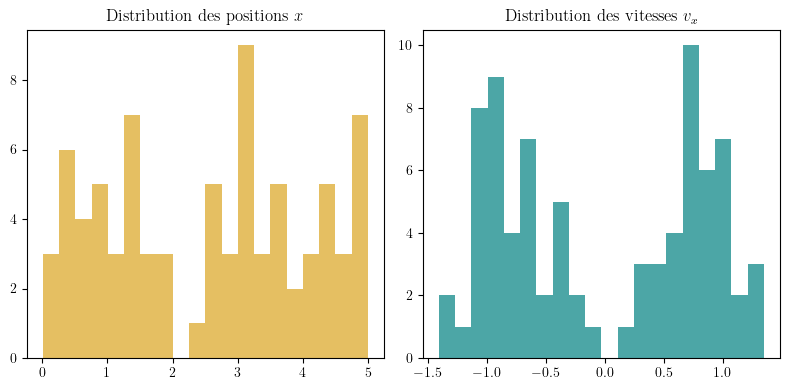

✅ Animation enregistrée : outputs/positions_animation.mp4
Moment d’ordre 2 : 0.7986195060627335


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"],
    "figure.figsize": (5, 5)
})


# ================================================================
# 🔹 1. Classe ParticleSystem : dynamique et intégration
# ================================================================
class ParticleSystem:
    def __init__(self, num_balls=100, box_size=5, ball_radius=0.09, dt=0.05, T=0.12):
        self.num_balls = num_balls
        self.box_size = box_size
        self.ball_radius = ball_radius
        self.dt = dt
        self.T = T

        # États
        self.positions = np.zeros((num_balls, 2))
        self.velocities = np.zeros((num_balls, 2))

    # --------------------
    # Initialisations
    # --------------------
    def init_positions(self, mode="uniform", centers=None, sigmas=None):
        if mode == "uniform":
            self.positions = np.random.rand(self.num_balls, 2) * self.box_size
        elif mode == "gaussian":
            if centers is None:
                centers = [self.box_size / 2, self.box_size / 2]
            if sigmas is None:
                sigmas = [1, 1]
            self.positions = np.random.normal(centers, sigmas, (self.num_balls, 2))
        elif mode == "double_gaussian":
            half = self.num_balls // 2
            self.positions[:half] = np.random.normal([1.5, 2.5], [0.3, 0.3], (half, 2))
            self.positions[half:] = np.random.normal([3.5, 2.5], [0.3, 0.3], (self.num_balls - half, 2))
        else:
            raise ValueError(f"Mode de position '{mode}' inconnu.")

    def init_velocities(self, mode="maxwell", sigma=None, means=None):
        if mode == "uniform":
            self.velocities = np.random.uniform(-1.0, 1.0, (self.num_balls, 2))
        elif mode == "maxwell":
            sigma = np.sqrt(self.T) if sigma is None else sigma
            self.velocities = np.random.normal(0.0, sigma, (self.num_balls, 2))
        elif mode == "double_gaussian":
            half = self.num_balls // 2
            mean1, mean2 = (means or [[-0.8, 0], [0.8, 0]])
            sigma = sigma or [0.3, 0.3]
            self.velocities[:half] = np.random.normal(mean1, sigma, (half, 2))
            self.velocities[half:] = np.random.normal(mean2, sigma, (self.num_balls - half, 2))
        else:
            raise ValueError(f"Mode de vitesse '{mode}' inconnu.")

    # --------------------
    # Mise à jour temporelle
    # --------------------
    def update(self):
        self.positions += self.velocities * self.dt

        # Bords périodiques
        self.positions %= self.box_size

        # Collisions simples (élastiques)
        for i in range(self.num_balls):
            for j in range(i + 1, self.num_balls):
                diff = self.positions[i] - self.positions[j]
                dist = np.linalg.norm(diff)
                if dist < 2 * self.ball_radius:
                    direction = diff / dist
                    dv = self.velocities[i] - self.velocities[j]
                    impulse = np.dot(dv, direction) * direction
                    self.velocities[i] -= impulse
                    self.velocities[j] += impulse


# ================================================================
# 🔹 2. Classe PhysicalAnalysis : étude physique
# ================================================================
class PhysicalAnalysis:
    def __init__(self, system: ParticleSystem):
        self.system = system

    def compute_moments(self, order=2):
        """Retourne les moments d'ordre donné sur les vitesses."""
        v = np.linalg.norm(self.system.velocities, axis=1)
        return np.mean(v ** order)

    def plot_histograms(self, save_dir=None):
        """Histogrammes des positions et vitesses."""
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].hist(self.system.positions[:, 0], bins=20, color="goldenrod", alpha=0.7)
        axes[0].set_title("Distribution des positions $x$")
        axes[1].hist(self.system.velocities[:, 0], bins=20, color="teal", alpha=0.7)
        axes[1].set_title("Distribution des vitesses $v_x$")
        plt.tight_layout()

        if save_dir:
            plt.savefig(os.path.join(save_dir, "histograms.png"), dpi=200)
        plt.show()


# ================================================================
# 🔹 3. Classe AnimationManager : sauvegarde & rendu
# ================================================================
class AnimationManager:
    def __init__(self, system: ParticleSystem, output_dir="outputs"):
        self.system = system
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def animate_positions(self, n_frames=200, fps=24, fmt="gif"):
        fig, ax = plt.subplots()
        ax.set_xlim(0, self.system.box_size)
        ax.set_ylim(0, self.system.box_size)
        ax.set_xticks([]); ax.set_yticks([])
        scat, = ax.plot([], [], 'o', color='teal', ms=self.system.ball_radius * 85)

        def init():
            scat.set_data([], [])
            return scat,

        def update(frame):
            self.system.update()
            scat.set_data(self.system.positions[:, 0], self.system.positions[:, 1])
            return scat,

        ani = FuncAnimation(fig, update, frames=n_frames, init_func=init, blit=True, interval=50)

        file_path = os.path.join(self.output_dir, f"2D_positions_animation.{fmt}")
        if fmt == "gif":
            ani.save(file_path, writer="imagemagick", fps=fps, dpi=200)
        elif fmt == "mp4":
            ani.save(file_path, writer="ffmpeg", fps=fps, dpi=200)

        plt.close(fig)
        print(f"✅ Animation enregistrée : {file_path}")


# ================================================================
# 🔹 Exemple d’utilisation
# ================================================================
if __name__ == "__main__":
    system = ParticleSystem(num_balls=80, T=0.1)
    system.init_positions(mode="uniform")
    system.init_velocities(mode="double_gaussian")

    analysis = PhysicalAnalysis(system)
    manager = AnimationManager(system)

    analysis.plot_histograms()
    manager.animate_positions(fmt="mp4")
    print("Moment d’ordre 2 :", analysis.compute_moments(order=2))


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

plt.rcParams["figure.figsize"] = (6,3)
plt.rcParams["figure.figsize"] = (6,3)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"],
})

###########################################
# Paramètres
num_balls = 100
ball_radius = 0.09
box_size = 5
dt = 0.05
Nt = 200
Nimages= 200
##------------------------------------------
# Paramètres distribution Maxwell-Boltzmann
T = 0.12   # Température (kb = m = hbar = 1)
##------------------------------------------
flag_print = 0
###########################################

sigma = np.sqrt(T)

# Initialisation des positions et vitesses des balles
positions = np.random.rand(num_balls, 2) * box_size
# velocities = np.random.randn(num_balls, 2)
velocities = np.random.uniform(-1.0,1.0, (num_balls,2))
# velocities =  np.random.normal(0.0, sigma, (num_balls,2))    # Distribution de Maxwell Boltzmann (loi normale)


plt.figure()
plt.hist(np.rot90(velocities)[0],20,color = "goldenrod")
plt.show() 

plt.figure()
plt.hist(np.rot90(velocities)[1],20,color = "goldenrod")
plt.show()

if flag_print:
    print(positions)
    print(velocities)

# Création de la figure avec une taille fixe
fig, ax = plt.subplots(figsize=(4, 4))  # Taille de la figure : 6 pouces x 6 pouces
ax.set(xlim=(0, box_size), ylim=(0, box_size))
ax.set_xticks([])
ax.set_yticks([])
balls, = ax.plot([], [], 'o', color = "teal", ms=ball_radius*85)

# Ajout de la grille
# ax.grid(True)

# Dessiner la grille manuellement
for i in range(1, int(box_size)):
    ax.plot([i, i], [0, box_size], color='gray', linestyle='--')
    ax.plot([0, box_size], [i, i], color='gray', linestyle='--')

# Fonction d'initialisation de l'animation
def init():
    balls.set_data([], [])
    return balls,

# Fonction de mise à jour de l'animation
def update(frame):
    global velocities

    # Mise à jour des positions des balles en fonction de leurs vitesses
    old_positions = np.copy(positions)
    positions[:] += velocities * dt
    
    # Gestion des rebonds sur les bords de la boîte
    for i in range(num_balls):
        for j in range(2):
            if positions[i, j] < 0:
                positions[i, j] = box_size
            elif positions[i, j] > box_size:
                positions[i, j] = 0

    # Détection et gestion des collisions entre les balles
    for i in range(num_balls):
        for j in range(i + 1, num_balls):
            dist = np.linalg.norm(positions[i] - positions[j])
            if dist < 2*ball_radius:  # Collision détectée
                # Calcul du vecteur de collision et de l'impulsion
                direction = (positions[j] - positions[i]) / dist
                impulse = np.dot(velocities[j] - velocities[i], direction) * direction
                
                # Mise à jour des vitesses des balles en fonction de la collision
                velocities[i] += impulse
                velocities[j] -= impulse
                
#                 positions[i] = old_positions[i]
#                 positions[j] = old_positions[j]

#     # Mise à jour des positions des balles en fonction de leurs vitesses
#     positions[:] += velocities * dt

    # Mise à jour de la position des balles dans l'animation
    balls.set_data(positions[:, 0], positions[:, 1])
    return balls,

# Création de l'animation
ani = FuncAnimation(fig, update, frames=np.arange(0,Nimages), init_func=init, blit=True, interval = 1000)

# Enregistrement de l'animation en tant que GIF
ani.save('collision_animation_2D_grille.gif', writer='imagemagick', fps = 24, dpi = 200)

# Affichage de l'animation
plt.show()

plt.figure()
plt.hist(np.rot90(velocities)[0], 20,color = "goldenrod")
plt.show() 

plt.figure()
plt.hist(np.rot90(velocities)[1],20,color = "goldenrod")
plt.show()
